# Inversion of ERT transects

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
from resipy import Project

ERTdatadir = 'data/ERT/'

c:\Users\mendo\anaconda3_2\Lib\site-packages\resipy\meshTools.py:56: UserWarning: pyvista not installed, 3D meshing viewing options will be limited
  warnings.warn('pyvista not installed, 3D meshing viewing options will be limited')


API path =  c:\Users\mendo\anaconda3_2\Lib\site-packages\resipy
ResIPy version =  3.5.4
cR2.exe found and up to date.
R3t.exe found and up to date.
cR3t.exe found and up to date.


In [2]:
# Parameters
extract = 0.5 # 0.5 and 2.5

## Middelkerke

In [3]:
# reading electrode position
dfm = pd.read_csv(ERTdatadir + 'electrode_locations_Middelkerke.csv')
elec = np.zeros((120, 3))
elec[:, 0] = dfm['distance'].values
dfm.head()

,ID,distance,easting,northing
0,1,0.0,41665.091,204320.014
1,2,0.5,41665.283,204319.552
2,3,1.0,41665.475,204319.091
3,4,1.5,41665.667,204318.629
4,5,2.0,41665.858,204318.167


Working directory is: c:\Users\mendo\anaconda3_2\Lib\site-packages\resipy
clearing dirname
filterData: 0 / 1693 quadrupoles removed.
308/1693 reciprocal measurements found.
32 measurements error > 20 %


c:\Users\mendo\anaconda3_2\Lib\site-packages\resipy\Project.py:2941: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  array = self.surveys[0].df[['a','b','m','n']].replace(lookupDict).values.copy().astype(int) # strings don't have max/min
c:\Users\mendo\anaconda3_2\Lib\site-packages\resipy\Project.py:2941: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  array = self.surveys[0].df[['a','b','m','n']].replace(lookupDict).values.copy().astype(int) # strings don't have max/min


19 measurements outside [0,6183.725257533959] removed!
filterData: 29 / 1674 quadrupoles removed.
29 measurements with greater than 20.0% reciprocal error removed!
Error model is R_err = 0.005 R_avg^0.577 (R^2 = 0.758)


c:\Users\mendo\anaconda3_2\Lib\site-packages\resipy\Project.py:2941: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  array = self.surveys[0].df[['a','b','m','n']].replace(lookupDict).values.copy().astype(int) # strings don't have max/min


Creating triangular mesh...done (73189 elements)


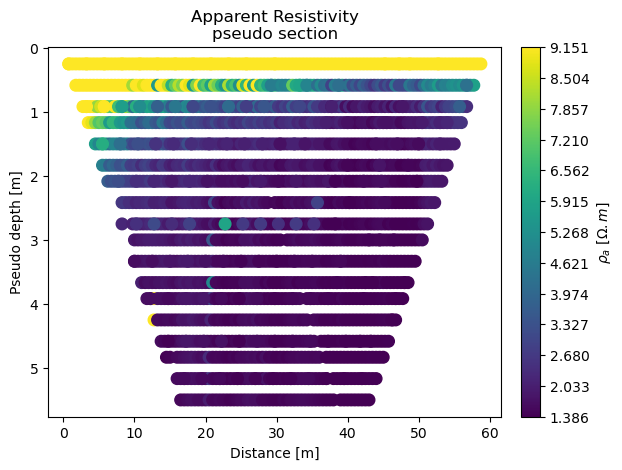

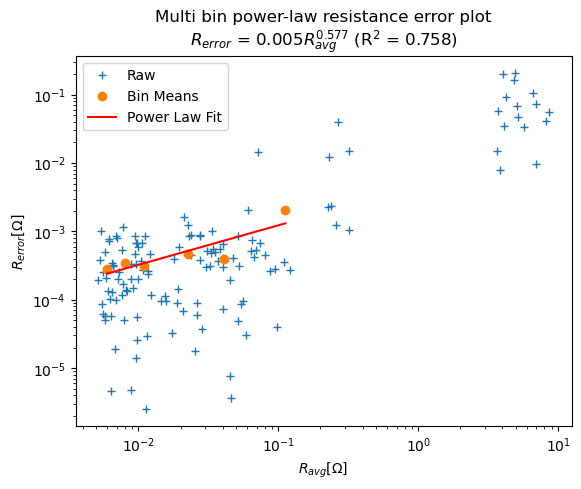

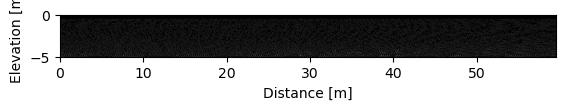

In [4]:
# invert
km = Project()
km.createSurvey(ERTdatadir + '23082301.csv', ftype='Syscal')
km.setElec(elec)
km.filterAppResist(vmin=0)
km.showPseudo()
km.filterRecip() 
km.fitErrorPwl()
km.createMesh('trian')
km.showMesh()

In [5]:
# invert
km.err = True  # use fitted error in the inversion
km.invert()

Writing .in file and protocol.dat... done

--------------------- MAIN INVERSION ------------------


 >> R  2    R e s i s t i v i t y   I n v e r s i o n   v4.10 <<

 >> D a t e : 05 - 07 - 2024
 >> My beautiful survey                                                             
 >> I n v e r s e   S o l u t i o n   S e l e c t e d <<
 >> Determining storage needed for finite element conductance matrix
 >> Generating index array for finite element conductance matrix
 >> Reading start resistivity from res0.dat                      
 >> R e g u l a r i s e d   T y p e <<
 >>   L i n e a r    F i l t e r    <<
 >> L o g - D a t a   I n v e r s i o n <<
 >> N o r m a l   R e g u l a r i s a t i o n <<
 >> D a t a   w e i g h t s   w i l l   b e  m o d i f i e d <<
 >> D a t a   w e i g h t   t o   b e   r e a d   f r o m   d a t a   f i l e <<


 Processing dataset   1


 Measurements read:  1507     Measurements rejected:     0
   Geometric mean of apparent resistivities:  0.24142E+01

 

c:\Users\mendo\anaconda3_2\Lib\site-packages\resipy\Project.py:6090: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(fname, delim_whitespace=True)


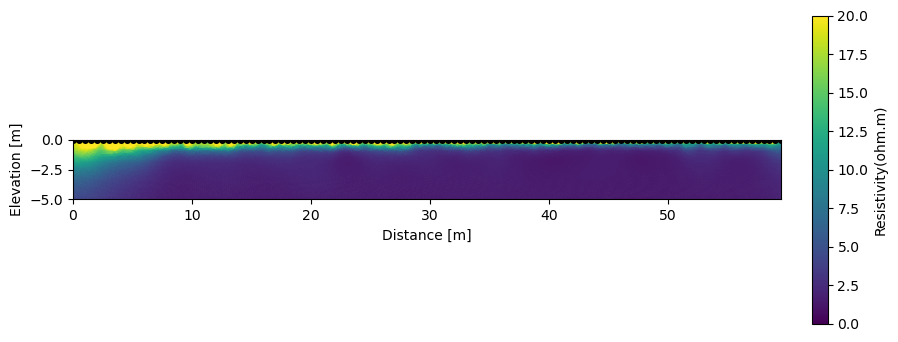

In [6]:
# inverted transect
fig, ax = plt.subplots(figsize=(10, 4))
km.showResults(ax=ax, sens=False, attr='Resistivity(ohm.m)', vmin=0, vmax=20)

In [8]:
# extract profiles
m_m = km.meshResults[0]
print(m_m)
#print(m_m.dfm)

dfs = []
for i in range(dfm.shape[0]):
    row = dfm.loc[i, :]
    ie = m_m.dfm['X'].between(row['distance'] - extract, row['distance'] + extract) & m_m.dfm['Z'].gt(-5) # 0.5 and 2.5
    sdf = m_m.dfm[ie][['Z', 'Resistivity(ohm.m)']]
    sdf['Z'] = sdf['Z'].round(1)
    #sdf['Z'] = (sdf['Z'] * 2).round(1) / 2
    sdf = sdf.groupby('Z').mean().reset_index()
    sdf['easting'] = row['easting']
    sdf['northing'] = row['northing']
    sdf['ID'] = row['ID']
    dfs.append(sdf)
dfmi = pd.concat(dfs)

print(dfmi)
dfmi.to_csv(ERTdatadir + 'middelkerke-inv-ERT-'+str(extract)+'.csv', index=False)

fig.savefig(ERTdatadir + 'middelkerke-inv-ERT-'+'.jpg', dpi=300)


_______mesh summary_______
Number of elements: 29850
Number of nodes: 15385
Number of cell vertices: 3
Number of cell attributes: 12
Dimensions: 2
original file path: c:\Users\mendo\anaconda3_2\Lib\site-packages\resipy\invdir\f001_res.vtk

______cell attributes_____
param
elm_id
region
cellType
X
Y
Z
Resistivity(ohm.m)
Resistivity(log10)
Sensitivity(log10)
Scaled_Sensitivity(log10)
Conductivity(mS/m)



AttributeError: 'Mesh' object has no attribute 'dfm'

In [ ]:
# figure of profiles
fig, ax = plt.subplots()
for el in dfm['ID'].unique():
    ie = dfm['ID'].eq(el)
    ax.plot(dfm[ie]['Resistivity(ohm.m)'], dfm[ie]['Z'], '-')
ax.set_xlabel('Resistivity [Ohm.m]')
ax.set_ylabel('Z [m]')
#fig.savefig(ERTdatadir + 'middelkerke-prof.jpg')

## Proefhoeve

In [ ]:
# reading electrode position
dfp = pd.read_csv(ERTdatadir + 'electrode_locations_Proefhoeve.csv')
dfp = dfp[:-1]
elec = np.zeros((60, 3))
elec[:, 0] = dfp['distance'].values
dfp.head()

,ID,distance,easting,northing
0,1,30.0,107761.108,183310.609
1,2,29.5,107761.387,183310.199
2,3,29.0,107761.668,183309.785
3,4,28.5,107761.949,183309.372
4,5,28.0,107762.230,183308.958


Working directory is: c:\Users\gmendoza\AppData\Local\anaconda3\Lib\site-packages\resipy
clearing dirname
filterData: 0 / 993 quadrupoles removed.
182/993 reciprocal measurements found.
4 measurements error > 20 %
3 measurements outside [0,74.02322483964478] removed!
filterData: 4 / 990 quadrupoles removed.
4 measurements with greater than 20.0% reciprocal error removed!
Error model is R_err = 0.012 R_avg^1.444 (R^2 = 0.963)
Creating triangular mesh...done (25688 elements)


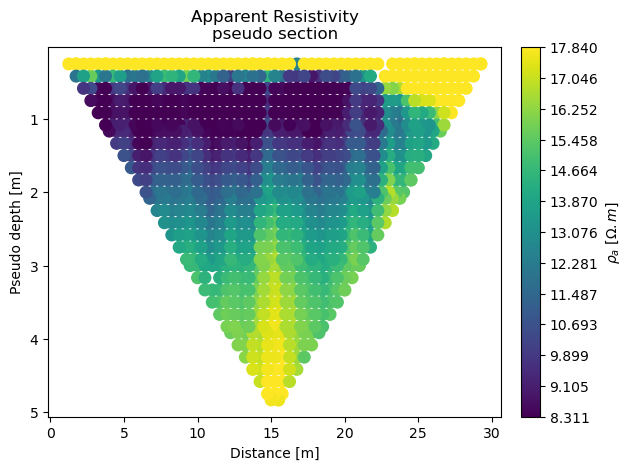

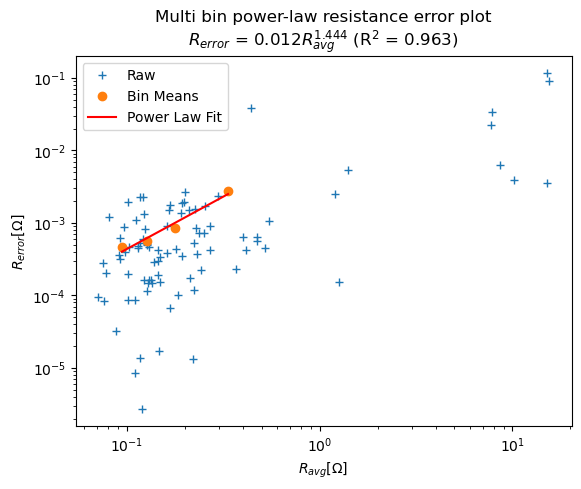

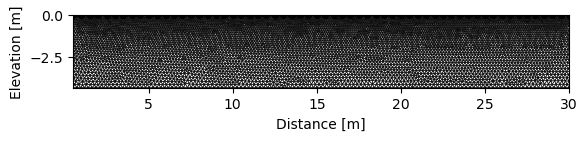

In [ ]:
kp = Project()
kp.createSurvey(ERTdatadir + '23082201.csv', ftype='Syscal')
kp.setElec(elec)
kp.filterAppResist(vmin=0)
kp.showPseudo()
kp.filterRecip() 
kp.fitErrorPwl()
kp.createMesh('trian')
kp.showMesh()

In [ ]:
# invert
kp.err = True  # use fitted error in the inversion
kp.invert()

Writing .in file and protocol.dat... done

--------------------- MAIN INVERSION ------------------


 >> R  2    R e s i s t i v i t y   I n v e r s i o n   v4.10 <<

 >> D a t e : 04 - 07 - 2024
 >> My beautiful survey                                                             
 >> I n v e r s e   S o l u t i o n   S e l e c t e d <<
 >> Determining storage needed for finite element conductance matrix
 >> Generating index array for finite element conductance matrix
 >> Reading start resistivity from res0.dat                      
 >> R e g u l a r i s e d   T y p e <<
 >>   L i n e a r    F i l t e r    <<
 >> L o g - D a t a   I n v e r s i o n <<
 >> N o r m a l   R e g u l a r i s a t i o n <<
 >> D a t a   w e i g h t s   w i l l   b e  m o d i f i e d <<
 >> D a t a   w e i g h t   t o   b e   r e a d   f r o m   d a t a   f i l e <<


 Processing dataset   1


 Measurements read:   897     Measurements rejected:     0
   Geometric mean of apparent resistivities:  0.12897E+02

 

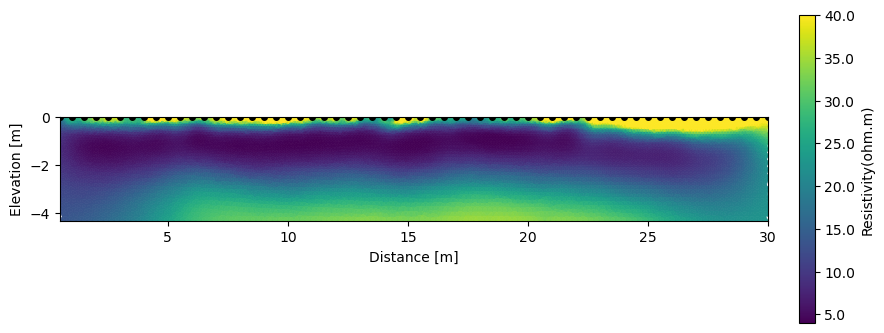

In [ ]:
# inverted transect
fig, ax = plt.subplots(figsize=(10, 4))
kp.showResults(ax=ax, attr='Resistivity(ohm.m)', sens=False, vmin=4, vmax=40)


In [ ]:
# extract profiles
mp = kp.meshResults[0]
pd.set_option('display.max_rows', None)

dfsp = []
for i in range(dfp.shape[0]):
    row = dfp.loc[i, :] # Each row of the original ERT positions
    mask = mp.df['X'].between(row['distance'] - extract, row['distance'] + extract) & mp.df['Z'].gt(-5) # Mask for each element of the ERT 
    sdf = mp.df[mask][['Z', 'Resistivity(ohm.m)']] # Depth and resistivity of the filtered elements
    sdf['Z'] = sdf['Z'].round(1)
    sdf = sdf.groupby('Z').mean().reset_index() # Take the mean
    print('mask', i, np.sum(mask))
    sdf['easting'] = row['easting']
    sdf['northing'] = row['northing']
    sdf['ID'] = row['ID'] # After taking the mean, each profile is set in the original ID
    dfsp.append(sdf)
dfpi = pd.concat(dfsp)
dfpi.to_csv(ERTdatadir + 'proefhoeve-inv-ERT-'+str(extract)+'.csv', index=False)

fig.savefig(ERTdatadir + 'proefhoeve-inv-ERT-'+'.jpg', dpi=300)

mask 0 1094
mask 1 1327
mask 2 1552
mask 3 1777
mask 4 2001
mask 5 2230
mask 6 2261
mask 7 2282
mask 8 2279
mask 9 2279
mask 10 2293
mask 11 2287
mask 12 2293
mask 13 2295
mask 14 2309
mask 15 2302
mask 16 2312
mask 17 2299
mask 18 2298
mask 19 2297
mask 20 2294
mask 21 2286
mask 22 2291
mask 23 2295
mask 24 2277
mask 25 2279
mask 26 2260
mask 27 2274
mask 28 2290
mask 29 2293
mask 30 2283
mask 31 2290
mask 32 2279
mask 33 2274
mask 34 2280
mask 35 2289
mask 36 2293
mask 37 2291
mask 38 2279
mask 39 2273
mask 40 2262
mask 41 2261
mask 42 2257
mask 43 2251
mask 44 2260
mask 45 2252
mask 46 2250
mask 47 2237
mask 48 2238
mask 49 2247
mask 50 2263
mask 51 2258
mask 52 2268
mask 53 2265
mask 54 2234
mask 55 2009
mask 56 1785
mask 57 1565
mask 58 1336
mask 59 1104


In [ ]:
# figure of profiles
fig, ax = plt.subplots()
for el in dfpi['ID'].unique():
    ie = dfpi['ID'].eq(el)
    ax.plot(dfpi[ie]['Resistivity(ohm.m)'], dfpi[ie]['Z'], '-')
ax.set_xlabel('Resistivity [Ohm.m]')
ax.set_ylabel('Z [m]')
#fig.savefig(datadir + 'proefhoeve-prof.jpg')